# Plot smooth min 

Notebook to show the approximations used to compute hFac, rLow, and rSurf in a smooth way in order to compute derivatives w.r.t. rLow

1. Show smooth approximation to hFac if statements for various hFacMin values
2. Show smooth min for various parameter values
3. Decide if currently implemented smooth approximations are a good idea

In [1]:
import os
import sys
from copy import deepcopy
import numpy as np
import xarray as xr
import xgcm
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
%matplotlib notebook

# functions and plot scripts are in immediate path...
#sys.path.insert(0,'./')
import plotSmoothMin as psm

## 1. hFac if statements

Normally hFac is computed with the set of if statements shown in plotSmoothMin.reg_hFac
See the smooth version here 

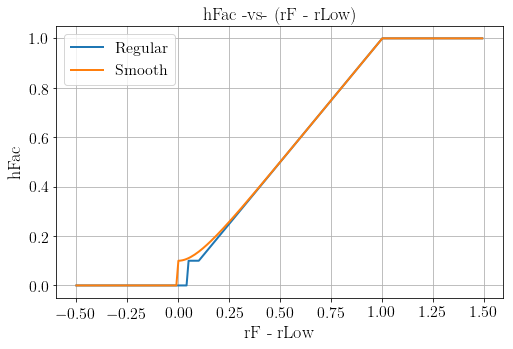

In [2]:
# --- Test vectors & parameters
hFac = np.arange(-0.5,1.5,0.01)
hFacInf = 0.1

# --- Make the plot
plt.figure(figsize=(8,5))
plt.plot(hFac,psm.reg_hFac(hFac,hFacMin=hFacInf),
         hFac,psm.smooth_hFac(hFac,hFacMin=hFacInf))
plt.legend(('Regular','Smooth'))
plt.title('hFac -vs- (rF - rLow)')
plt.xlabel('rF - rLow')
plt.ylabel('hFac')
plt.grid()
plt.show()

Notice difference in range `(rF(k) - rLow)` $\in$ (0, 0.5`hFacMin`) especially.
This amounts to depth differences of roughly 2-3m (since $\delta R$ = 20m.
Note: Changing threshold to 0.5`hFacMin` makes the impact of smoothing <=1m on `rLow` and rather than 2-3m for each

See difference between half and original threshold in `figures/smooth_hfac/rLow*`

On the positive: this version results in smoothness as desired: 

- only want dJ/drLow at points where rF-rLow $\in (0,1]$ 
- So if statements for `(rF - rLow)`<=0 and >1 ok because don't care about smoothness there
- and when `rF-rLow`=1, smooth approx =1, so we really are in this regime

Considering uncertainties...
- this gives a map from the bathymetry to the representation within the model that allows for a well-behaved flow, which is not reality.
- so in order to take the result of an optimization problem seriously, the adjustments >> adjustments from this map, which is at most `hFacMin`$\delta R$


### But, this version causes blow up in PIG

I'm talking NaNs ... NaNs everywhere.

See blow up in figure `figures/smooth_hfac/eta_sm_ns_origThreshold.png`

### Also,

there's a small issue with some `(rF(k) - rLow)` values producing nonzero hFac that is less than `hFacMin`. See plotUpdateMasksDebug.ipynb for details. This is not the main issue though.

below is a version which uses 0.5`hFacMin` as a minimum threshold. 
Smoothness now only upheld in 0.5`hFacMin`...

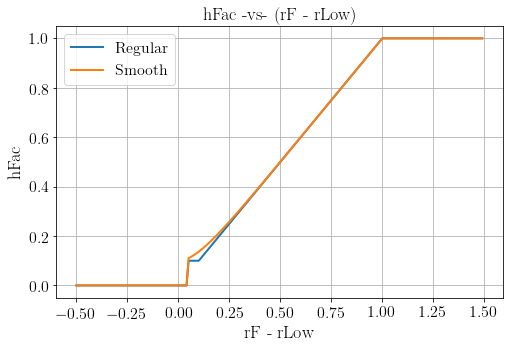

In [3]:
plt.figure(figsize=(8,5))
plt.plot(hFac,psm.reg_hFac(hFac,hFacMin=hFacInf),
         hFac,psm.smooth_hFac(hFac,hFacMin=hFacInf,minThreshold=0.5*hFacInf))
plt.legend(('Regular','Smooth'))
plt.title('hFac -vs- (rF - rLow)')
plt.xlabel('rF - rLow')
plt.ylabel('hFac')
plt.grid()
plt.show()

This version "runs" just fine, but there is noise generated in the `rLow` field which gets propagated into modeled quantities. 

See `figures/smooth_hfac/eta_sm_ns_halfThreshold.png` which is basically the propagated version (?) of noise in the rLow field `figures/smooth_hfac/rLowC_ns_sm_diff_halfThreshold.png` 

### New version, using splines

Define hFac function $f$ as 

$ f(x) = 
\begin{cases}
    0, & x < 0.5 x_0 \\
    x_0, & 0.5 x_0 \le x \le x_0 \\
    g(x), & x_0 \le x \le x_1 \\
    x, & x_1 \le x \le 1
    1, & x > 1
\end{cases}
$

where $x_0$ = `hFacMin` and $x_1$ = `hFacMin` + $\epsilon$, where the new parameter `smoothHFacEps` = $\epsilon$ controls the region of smooth transition between `hFacMin` and linear.

g(x) is the cubic spline function

$ g(x) := a(x-x_0)^3 + b(x-x_0)^2 +c(x-x_0) + d $

where we prescribe

$ g(x) = 
\begin{cases}
   x_0, & x = x_0 \\
   x_1, & x = x_1 \\
\end{cases}
$
$ g'(x) = 
\begin{cases}
   0, & x = x_0 \\
   1, & x = x_1 \\
\end{cases}
$

which implies that $a = -\frac{1}{\epsilon^2}$, $b = \frac{2}{\epsilon}$, $c=0$, $d = x_0$

<IPython.core.display.Javascript object>


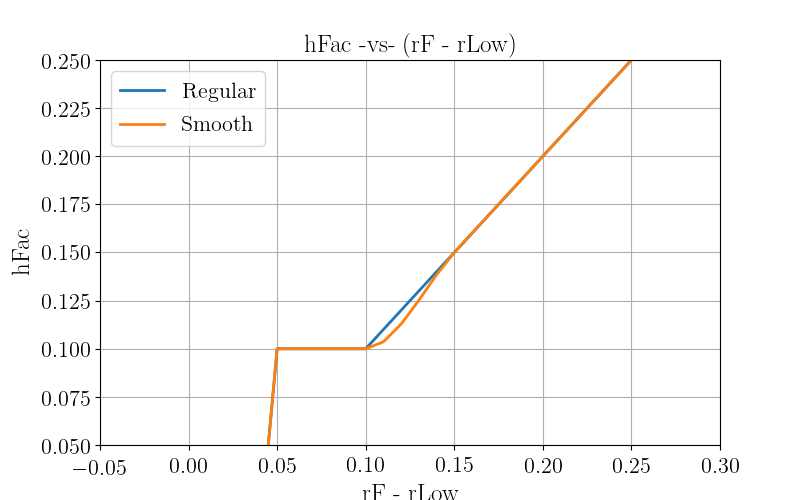

In [11]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(hFac,psm.reg_hFac(hFac,hFacMin=hFacInf),
         hFac,psm.smooth_hFac2(hFac,hFacMin=hFacInf,epsilon=0.05))
plt.legend(('Regular','Smooth'))
plt.title('hFac -vs- (rF - rLow)')
plt.xlabel('rF - rLow')
plt.ylabel('hFac')
plt.xlim((-.05,0.3))
plt.ylim((0.05,0.25))
plt.grid()
plt.show()

This version is nice because it does the proper thresholding, and uses an intuitive parameter to define the smooth transition from `hFacMin` to a linear function.

This defines much smaller differences in `rLowC/W/S` and `rSurfC/W/S`, see `figures/smooth_hFac/rLow*spline_1m1.png` for `epsilon`=0.1. 
Differences are < 1m as opposed to the other definitions.

#### Reducing noise
This still propagates some noise into the $\eta$ field, see `figures/smooth_hFac/eta_sm_ns_spline_1m1.png`. 
However, the noise is much smaller than the halfThreshold case. 
Smooth/nonsmooth difference starts at an order of magnitude smaller than $\eta$, then by the end of 3 days drops to 2 orders of magnitude smaller.

For halfThreshold, have noise an order of magnitude larger.

#### Sensitivity experiment
And test the adjoint. This may suffer from the fact that it has a similarly inaccurate adjoint to the non smooth version.

## 2. Smooth min -vs- real min 

Currently the smooth min approximation is 

$$\text{smin}(x,y) = \frac{1}{2} ( x+y - \text{sabs}(x-y) )$$

where        

$$ \text{sabs}(z) = 
\begin{cases}
    z = z, &\qquad x \ge \beta \\
    z =-z, &\qquad x \le \beta \\
    z = \frac{\beta}{10}\log( \frac{1}{2} \exp(10\frac{z}{\beta}) + \exp(10\frac{z}{\beta})),
        &\qquad \text{otherwise}
\end{cases}
$$

where $\beta=$`smoothAbsFuncRange` in `data`, and determines the range within which to be a smooth function. But this implies there's a jump outside of this range ... lets check it out

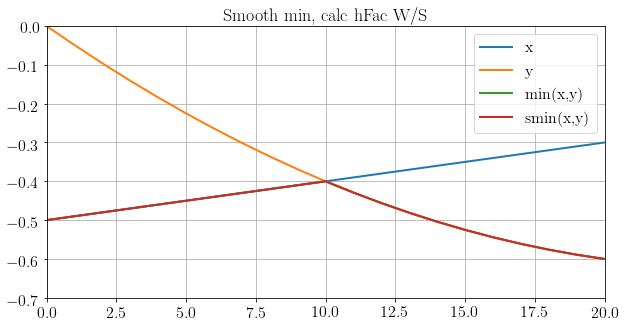

In [4]:
# --- More variables
fact = np.arange(0.0,20.0,0.1,dtype=np.float64)
hFac2 = np.multiply(fact,hFac)
n = np.arange(len(hFac))

# --- Smooth function in MITgcm
smoothAbsFuncRange = 0.01
plt.figure(figsize=(10,5))
psm.plot_min(hFac,hFac2,
         psm.smooth_min(hFac,hFac2,alpha=smoothAbsFuncRange))
plt.title('Smooth min, calc hFac W/S')
plt.ylim(-0.7,0)
plt.xlim(0,20)
plt.grid()
plt.show()

Setting the smooth min parameter a little more aggressively shows the differences...

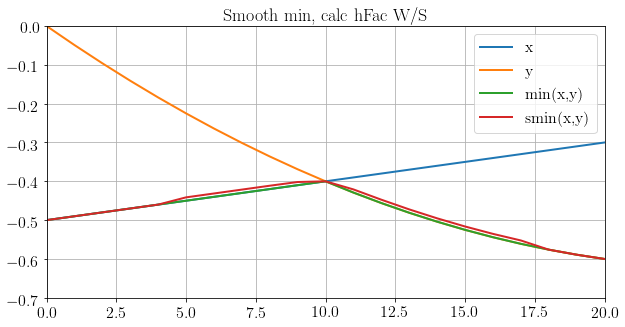

In [5]:
# --- Smooth function in MITgcm
smoothAbsFuncRange = 0.25 
plt.figure(figsize=(10,5))
psm.plot_min(hFac,hFac2,
         psm.smooth_min(hFac,hFac2,alpha=smoothAbsFuncRange))
plt.title('Smooth min, calc hFac W/S')
plt.ylim(-0.7,0)
plt.xlim(0,20)
plt.grid()
plt.show()

Slight jumps are visible around 5.0 and 17.5. This seems like a bad replacement for a differentiable function. What about the smooth min function

$$ \text{smin2}(x,y) = \frac{x\exp(\alpha x) + y\exp(\alpha y)}{\exp(\alpha x) + \exp(\alpha y)} $$

No jumps, and a seemingly more intuitive parameter $\alpha$.

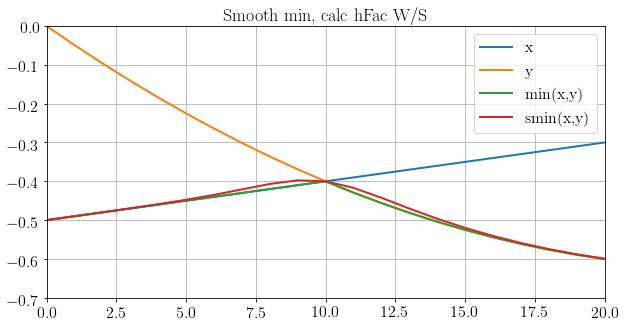

In [6]:
# --- New smooth min
alpha_val = -20 
plt.figure(figsize=(10,5))
psm.plot_min(hFac,hFac2,
         psm.smooth_min_2(hFac,hFac2,alpha=alpha_val))
plt.title('Smooth min, calc hFac W/S')
plt.ylim(-0.7,0)
plt.xlim(0,20)
plt.grid()
plt.show()

Questions: 
1. Which function to use? Which is smoother? Which is more accurate representation of $\min$?
2. How to determine the parameter? 

Theoretically, this seems like a better replacement simply on the grounds that the other definition will have a jump defined by the range parameter. However, the jumps won't matter if $\beta$ is small enough in every case where it is employed.

Before coding it into the MITgcm, lets check out the derivative. Suppose $x,y$ vary with coordinate $\eta$, then

$$ 
\frac{d\text{sm2}}{d\eta} = \frac{\partial \text{sm2}}{\partial{x}}\frac{\partial x}{\partial \eta} +\frac{\partial \text{sm2}}{\partial{y}}\frac{\partial y}{\partial \eta} 
$$

So the thing that matters is $\frac{\partial \text{sm2}}{\partial x}$,

$$
\frac{\partial \text{sm2}}{\partial x} = 
\frac{\exp(\alpha x) + \alpha x \exp(\alpha x)}{\exp(\alpha x) + \exp(\alpha y)} -
\frac{\alpha \exp(\alpha x) (x \exp(\alpha x) + y \exp(\alpha y) )}{(\exp(\alpha x) + \exp(\alpha y))^2}
$$

and similar for y ...